# XGBoost - Entrenament i resultats

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import datetime
import random

import pickle
import time

from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Càrrega i preparació de dades

In [2]:
X_data = np.load('/kaggle/input/tfm2a-preparar-dades/X_minMaxScaled_opt.npy')
Y_data = np.load('/kaggle/input/tfm2a-preparar-dades/Y_FM.npy')
param_names = np.load('/kaggle/input/tfm2a-preparar-dades/Y_FM_names.npy')
X_wl_values = np.load('/kaggle/input/tfm2a-preparar-dades/X_wl_values.npy')
pca_labels = np.load('/kaggle/input/tfm1b-espectres/PCA_labels.npy')

In [3]:
# Separació de les dades en train i test
X_train, X_test, y_train_all, y_test_all, pca_labels_train, pca_labels_test = train_test_split(X_data, Y_data, pca_labels, test_size = 0.25, random_state = 42)

# Comprovem les dimensions de train i test
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train_all.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test_all.shape)

print('PCA-labels train Shape:', pca_labels_train.shape)
print('PCA-labels test Shape:', pca_labels_test.shape)

Training Features Shape: (68544, 52)
Training Labels Shape: (68544, 6)
Testing Features Shape: (22848, 52)
Testing Labels Shape: (22848, 6)
PCA-labels train Shape: (68544,)
PCA-labels test Shape: (22848,)


## Hiperparàmetres optimitzats

Funcions per carregar els valors òptims dels hiperparàmetres per a cada paràmetre atmosfèric.

Els valors òptims s'han determinat en una cerca en malla utilitzant la validació creuada.

In [4]:
# Definim el millor n_estimator per cada paràmetre atmosfèric
def get_best_n_estimator(nParam):
    if nParam == 0:
        return 2000
    elif nParam == 1:
        return 2000
    elif nParam == 2:
        return 2000
    elif nParam == 3:
        return 2000
    elif nParam == 4:
        return 6000
    elif nParam == 5:
        return 2000

In [5]:
# Definim la millor min_child_weight per cada paràmetre atmosfèric
def get_best_min_child_weight(nParam):
    if nParam == 0:
        return 1
    elif nParam == 1:
        return 6
    elif nParam == 2:
        return 1
    elif nParam == 3:
        return 1
    elif nParam == 4:
        return 6
    elif nParam == 5:
        return 3

In [6]:
# Definim la millor min_child_weight per cada paràmetre atmosfèric
def get_best_colsample_bytree(nParam):
    if nParam == 0:
        return 0.8
    elif nParam == 1:
        return 1
    elif nParam == 2:
        return 1
    elif nParam == 3:
        return 1
    elif nParam == 4:
        return 1
    elif nParam == 5:
        return 1

## Entrenament del model amb els millors hiperparàmetres

In [7]:
def runXGBoost(nParam):
    
    y_train = y_train_all[:, nParam]
    y_test = y_test_all[:, nParam]
    
    model = XGBRegressor(
        random_state = 24, tree_method='gpu_hist',        
        n_estimators = get_best_n_estimator(nParam),
        learning_rate = 0.1,
        max_depth = 5, 
        min_child_weight = get_best_min_child_weight(nParam),
        gamma = 0,
        subsample = 0.8,
        colsample_bytree = get_best_colsample_bytree(nParam)        
    )

    # Entrenament del model 
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("     |- Temps d'entrenament: ", round(elapsed_time,2), ' segons (', round(elapsed_time/60, 3), ' minuts).')
    
    # Guardem el model entrenat
    pickle.dump(model, open("XGBmodel" + str(nParam), "wb"))
    
    # Prediccions
    start_time = time.time()
    y_pred = model.predict(X_test) 
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("     |- Temps de predicció: ", round(elapsed_time,2), ' segons (', round(elapsed_time/60, 3), ' minuts).\n')
    
    return(y_pred)

In [8]:
start_time = time.time()
y_pred_df = pd.DataFrame()

for i in range(0,6):
    print(datetime.datetime.now(), ": Calculant paràmetre ", str(i), "(", param_names[i], ")")
    
    col_name = param_names[i]
    y_pred = runXGBoost(i)
    y_pred_df[col_name] = y_pred
    
    
end_time = time.time()
total_time = end_time - start_time
print("El temps total de l'execució és:", round(total_time, 2), "segons, o bé ", round(total_time/60, 3), " minuts.")

2023-06-18 11:01:15.667337 : Calculant paràmetre  0 ( planet_temp )
     |- Temps d'entrenament:  5.31  segons ( 0.089  minuts).
     |- Temps de predicció:  0.67  segons ( 0.011  minuts).

2023-06-18 11:01:21.702841 : Calculant paràmetre  1 ( log_H2O )
     |- Temps d'entrenament:  4.37  segons ( 0.073  minuts).
     |- Temps de predicció:  0.68  segons ( 0.011  minuts).

2023-06-18 11:01:26.795067 : Calculant paràmetre  2 ( log_CO2 )
     |- Temps d'entrenament:  4.47  segons ( 0.075  minuts).
     |- Temps de predicció:  1.07  segons ( 0.018  minuts).

2023-06-18 11:01:32.384283 : Calculant paràmetre  3 ( log_CH4 )
     |- Temps d'entrenament:  4.63  segons ( 0.077  minuts).
     |- Temps de predicció:  0.67  segons ( 0.011  minuts).

2023-06-18 11:01:37.731117 : Calculant paràmetre  4 ( log_CO )
     |- Temps d'entrenament:  12.41  segons ( 0.207  minuts).
     |- Temps de predicció:  2.1  segons ( 0.035  minuts).

2023-06-18 11:01:52.384746 : Calculant paràmetre  5 ( log_NH3 )
   

## Avaluació de la qualitat dels models

In [9]:
def calcular_metriques(nParam):
    # Dades y_test per aquest parametre
    y_test = y_test_all[:, nParam]
    y_train = y_train_all[:, nParam]
    
    # Model d'aquest paràmetre
    model = pickle.load(open("/kaggle/working/XGBmodel"+str(nParam), "rb"))
    
    # Calculem les prediccions del conjunt test
    y_pred = model.predict(X_test)
    
    # df amb totes les mètriques
    df = pd.DataFrame()
    df['nParam'] = [nParam]
    df['param_name'] = [param_names[nParam]]
    df['R2_score'] = [r2_score(y_test, y_pred)]
    df['MSE'] = [mean_squared_error(y_test, y_pred)]
    df['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df['MAPE'] = [mean_absolute_percentage_error(y_test, y_pred)]
    df['MedianAE'] = [median_absolute_error(y_test, y_pred)]
    
    df['test_score_R2'] = model.score(X_test, y_test) # R2 coeficient of determination
    df['train_score_R2'] = model.score(X_train, y_train) # R2 coeficient of determination
    
    df['test_R2_pca-1'] = model.score(X_test[pca_labels_test == -1], y_test[pca_labels_test == -1]) 
    df['test_R2_pca0'] = model.score(X_test[pca_labels_test == 0], y_test[pca_labels_test == 0]) 
    df['test_R2_pca1'] = model.score(X_test[pca_labels_test == 1], y_test[pca_labels_test == 1]) 
    df['test_R2_pca2'] = model.score(X_test[pca_labels_test == 2], y_test[pca_labels_test == 2]) 
    
    return(df)

In [10]:
totes_metriques = pd.concat([
    calcular_metriques(0), 
    calcular_metriques(1), 
    calcular_metriques(2), 
    calcular_metriques(3), 
    calcular_metriques(4), 
    calcular_metriques(5)], ignore_index = True)

totes_metriques

,nParam,param_name,R2_score,MSE,MAE,MAPE,MedianAE,test_score_R2,train_score_R2,test_R2_pca-1,test_R2_pca0,test_R2_pca1,test_R2_pca2
0,0,planet_temp,0.979900,9387.387474,36.269899,0.027820,18.076376,0.979900,0.998739,0.974371,0.984514,0.982242,0.984481
1,1,log_H2O,0.952017,0.143571,0.242288,0.036457,0.130641,0.952017,0.987765,0.958022,0.901084,0.976864,0.960331
2,2,log_CO2,0.991465,0.017889,0.081545,0.012343,0.054863,0.991465,0.998220,0.988009,0.989763,0.989617,0.995862
3,3,log_CH4,0.979491,0.061650,0.128105,0.019260,0.055658,0.979491,0.997050,0.976944,0.996633,0.882982,0.893601
4,4,log_CO,0.958380,0.031120,0.117724,0.026269,0.077120,0.958380,0.997574,0.949977,0.954373,0.969830,0.965759
5,5,log_NH3,0.904630,0.198911,0.283969,0.040647,0.150914,0.904630,0.976034,0.900623,0.836404,0.941662,0.937892


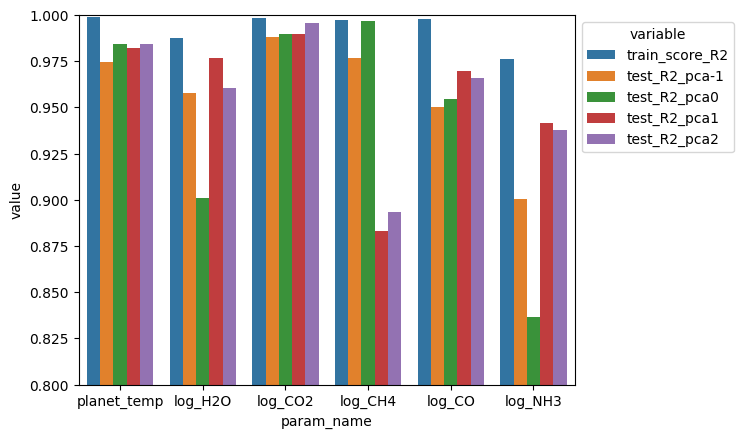

In [11]:
df_bar = pd.melt(
    totes_metriques[['param_name', 'train_score_R2', 'test_R2_pca-1', 'test_R2_pca0', 'test_R2_pca1','test_R2_pca2' ]], 
    id_vars=['param_name'], 
    value_vars=['train_score_R2', 'test_R2_pca-1', 'test_R2_pca0', 'test_R2_pca1','test_R2_pca2']
)

ax = sns.barplot(data=df_bar, x="param_name", y="value", hue="variable")
plt.ylim(0.8, 1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Comparacó entre els valors predits i els esperats

### Per totes les mostres del conjunt test

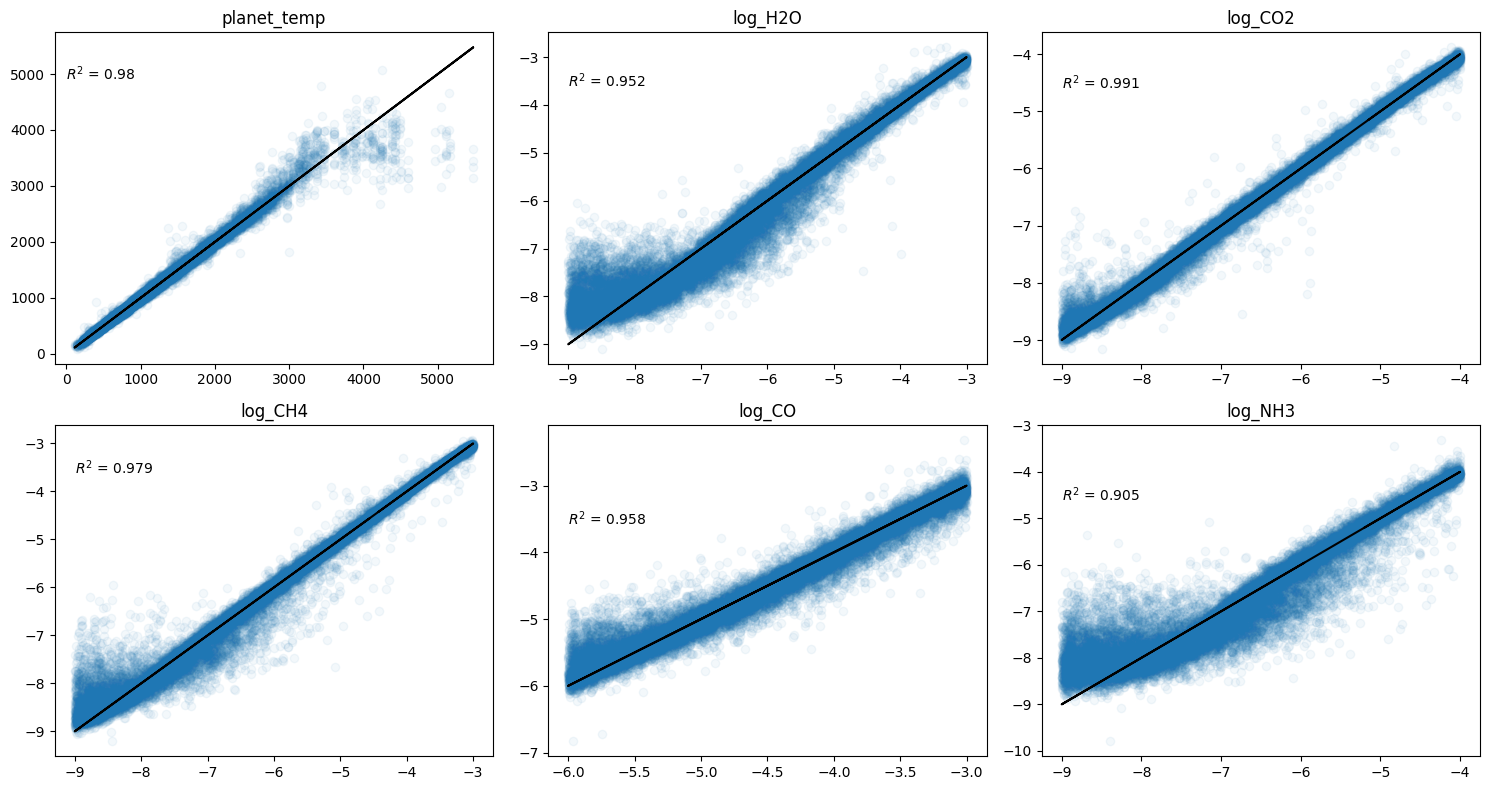

In [12]:
alpha_level = 0.05

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

x = y_test_all[:,0]; y = y_pred_df[param_names[0]]
axes[0,0].scatter(x, y, alpha = alpha_level) #, c=pca_labels_test
axes[0,0].plot(x, x,'k-')
axes[0,0].set(title = param_names[0])
R2 = r2_score(x, y)
axes[0,0].text(0, 5000, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,1]; y = y_pred_df[param_names[1]]
axes[0,1].scatter(x, y, alpha = alpha_level)
axes[0,1].plot(x, x, 'k-')
axes[0,1].set(title = param_names[1])
R2 = r2_score(x, y)
axes[0,1].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,2]; y = y_pred_df[param_names[2]]
axes[0,2].scatter(x, y, alpha = alpha_level)
axes[0,2].plot(x, x,'k-')
axes[0,2].set(title = param_names[2])
R2 = r2_score(x, y)
axes[0,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,3]; y = y_pred_df[param_names[3]]
axes[1,0].scatter(x, y, alpha = alpha_level)
axes[1,0].plot(x, x,'k-')
axes[1,0].set(title = param_names[3])
R2 = r2_score(x, y)
axes[1,0].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,4]; y = y_pred_df[param_names[4]]
axes[1,1].scatter(x, y, alpha = alpha_level)
axes[1,1].plot(x, x,'k-')
axes[1,1].set(title = param_names[4])
R2 = r2_score(x, y)
axes[1,1].text(-6, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,5]; y = y_pred_df[param_names[5]]
axes[1,2].scatter(x, y, alpha = alpha_level)
axes[1,2].plot(x, x,'k-')
axes[1,2].set(title = param_names[5])
R2 = r2_score(x, y)
axes[1,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

plt.tight_layout()
plt.show()

### Per cada grup espectral per separat

Els grups espectrals són grups d'espectres amb característiques més homoegènies, determinats amb PCA + DBSCAN.

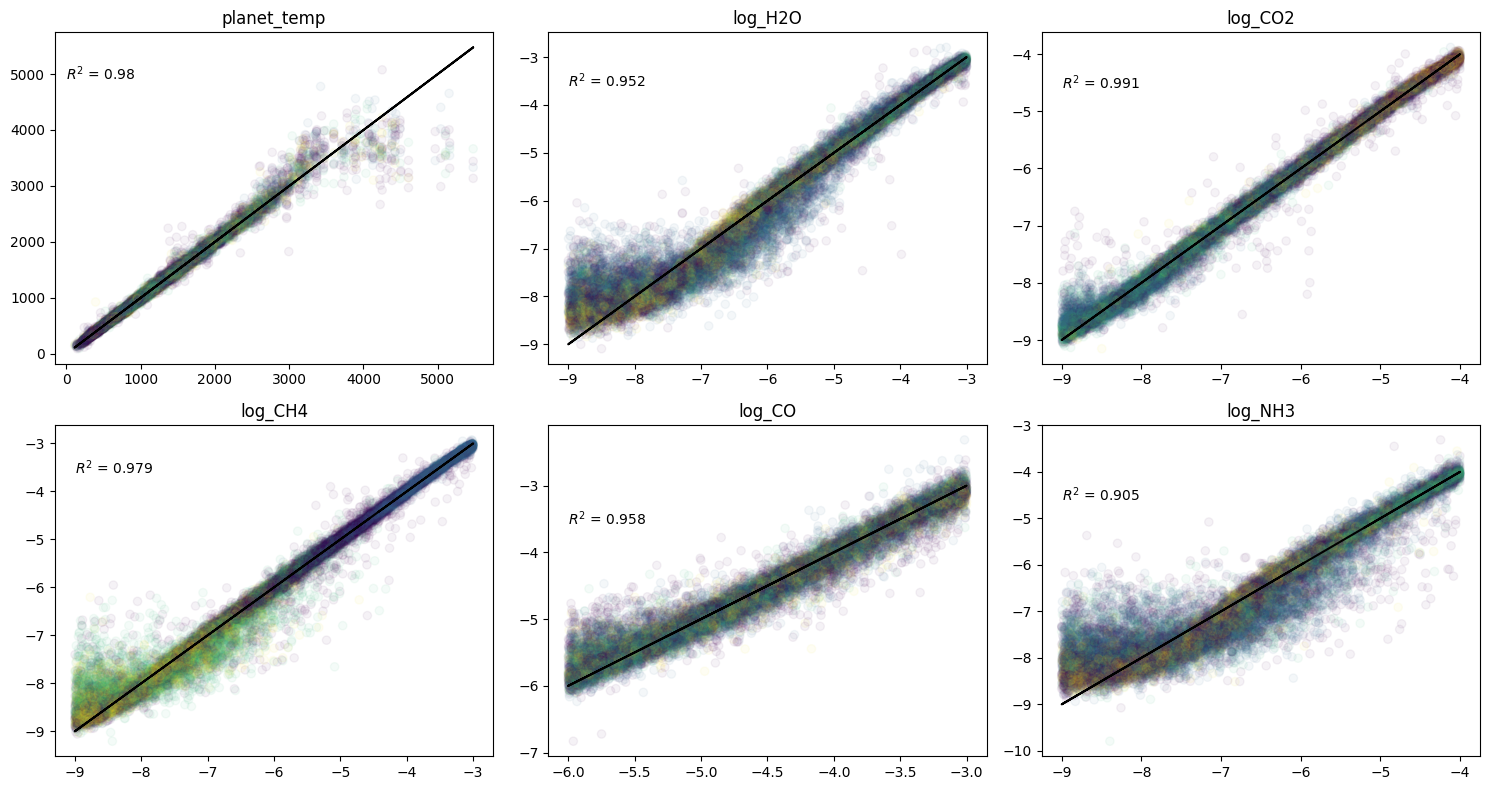

In [13]:
alpha_level = 0.05

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

x = y_test_all[:,0]; y = y_pred_df[param_names[0]]
axes[0,0].scatter(x, y, alpha = alpha_level, c=pca_labels_test) 
axes[0,0].plot(x, x,'k-')
axes[0,0].set(title = param_names[0])
R2 = r2_score(x, y)
axes[0,0].text(0, 5000, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,1]; y = y_pred_df[param_names[1]]
axes[0,1].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[0,1].plot(x, x, 'k-')
axes[0,1].set(title = param_names[1])
R2 = r2_score(x, y)
axes[0,1].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,2]; y = y_pred_df[param_names[2]]
axes[0,2].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[0,2].plot(x, x,'k-')
axes[0,2].set(title = param_names[2])
R2 = r2_score(x, y)
axes[0,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,3]; y = y_pred_df[param_names[3]]
axes[1,0].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[1,0].plot(x, x,'k-')
axes[1,0].set(title = param_names[3])
R2 = r2_score(x, y)
axes[1,0].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,4]; y = y_pred_df[param_names[4]]
axes[1,1].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[1,1].plot(x, x,'k-')
axes[1,1].set(title = param_names[4])
R2 = r2_score(x, y)
axes[1,1].text(-6, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,5]; y = y_pred_df[param_names[5]]
axes[1,2].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[1,2].plot(x, x,'k-')
axes[1,2].set(title = param_names[5])
R2 = r2_score(x, y)
axes[1,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

plt.tight_layout()
plt.show()

In [14]:
def get_y_pred(nParam):
    # Dades y_test per aquest parametre
    y_test = y_test_all[:, nParam]
    y_train = y_train_all[:, nParam]
    
    # Model d'aquest paràmetre
    model = pickle.load(open("/kaggle/working/XGBmodel"+str(nParam), "rb"))
    
    # Calculem les prediccions del conjunt test
    y_pred = model.predict(X_test)
    
    return(y_pred)

In [15]:
def scatterplot_by_group(nParam):

    df = pd.DataFrame()
    df['y_pred'] = get_y_pred(nParam)
    df['y_true'] = y_test_all[:,nParam]
    df['pca_label'] = pca_labels_test

    sns.relplot(data=df, x="y_true", y="y_pred", hue="pca_label", col="pca_label", alpha=0.1)

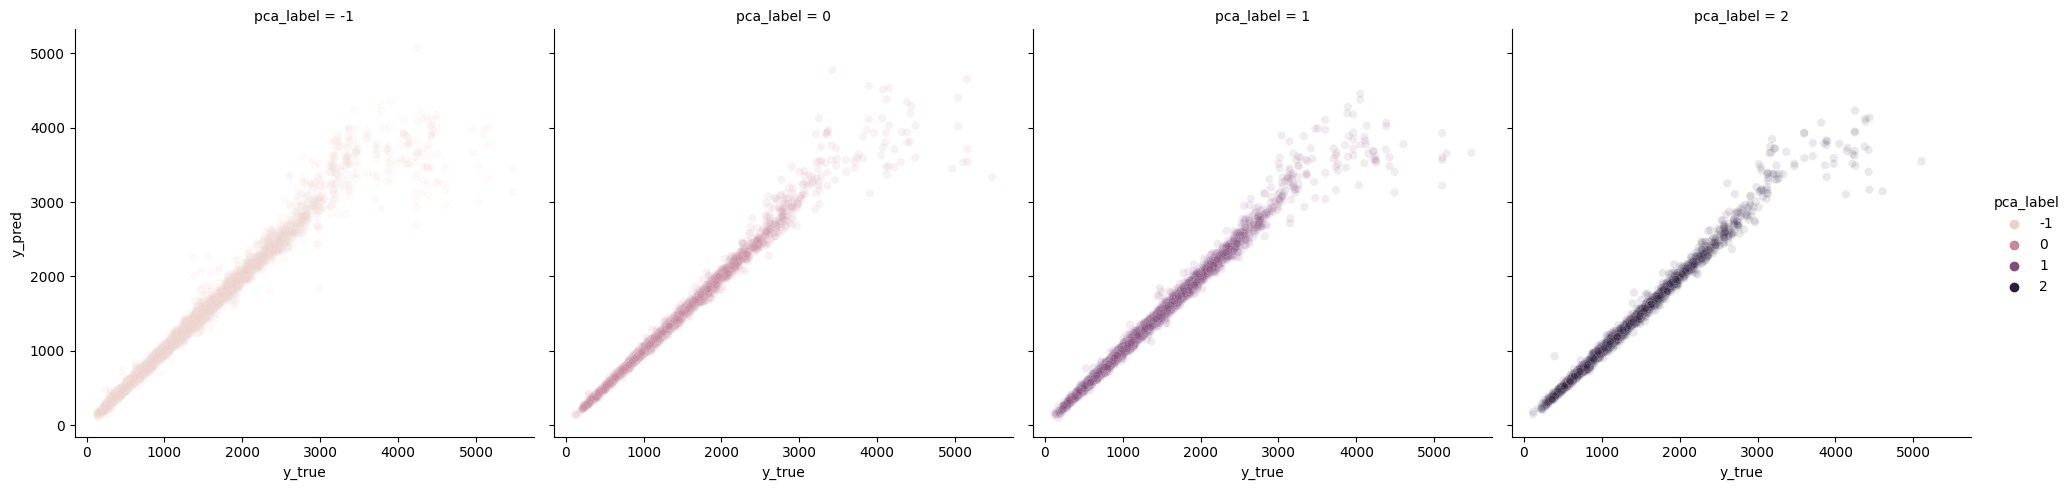

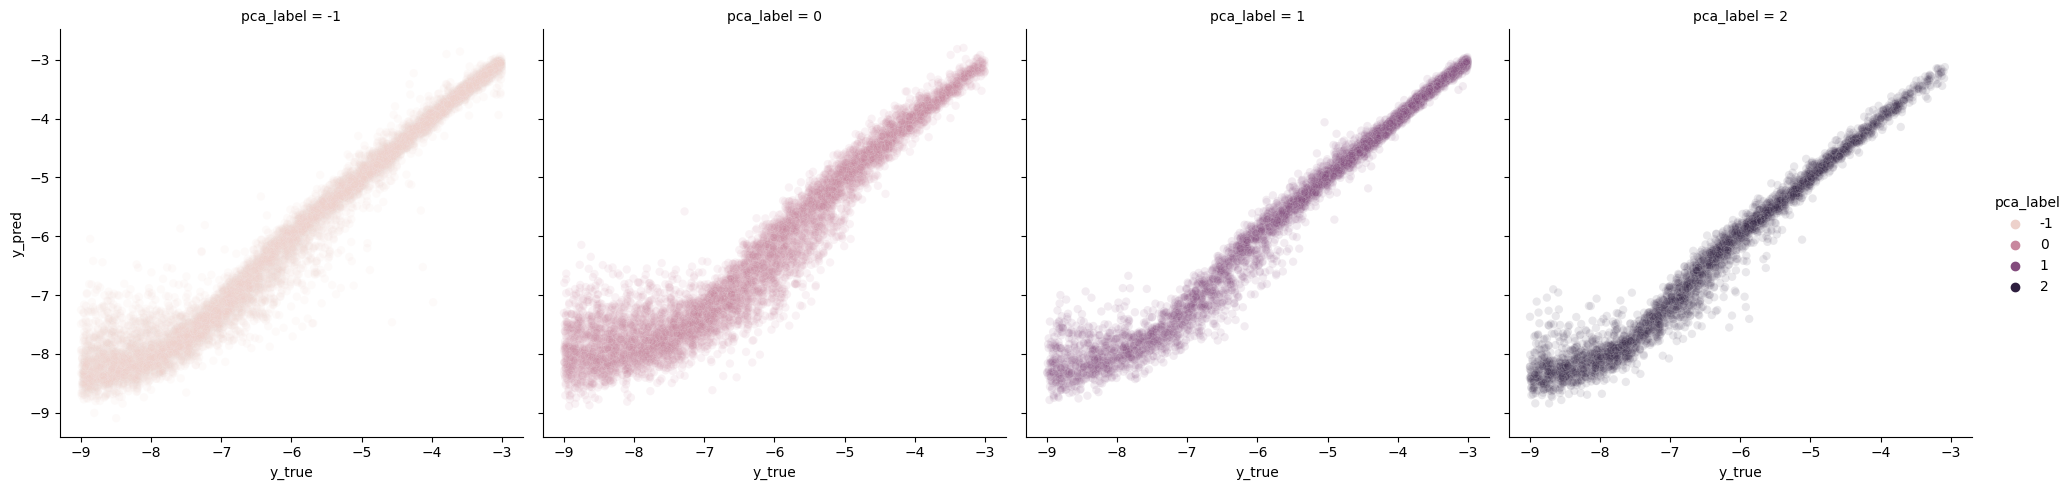

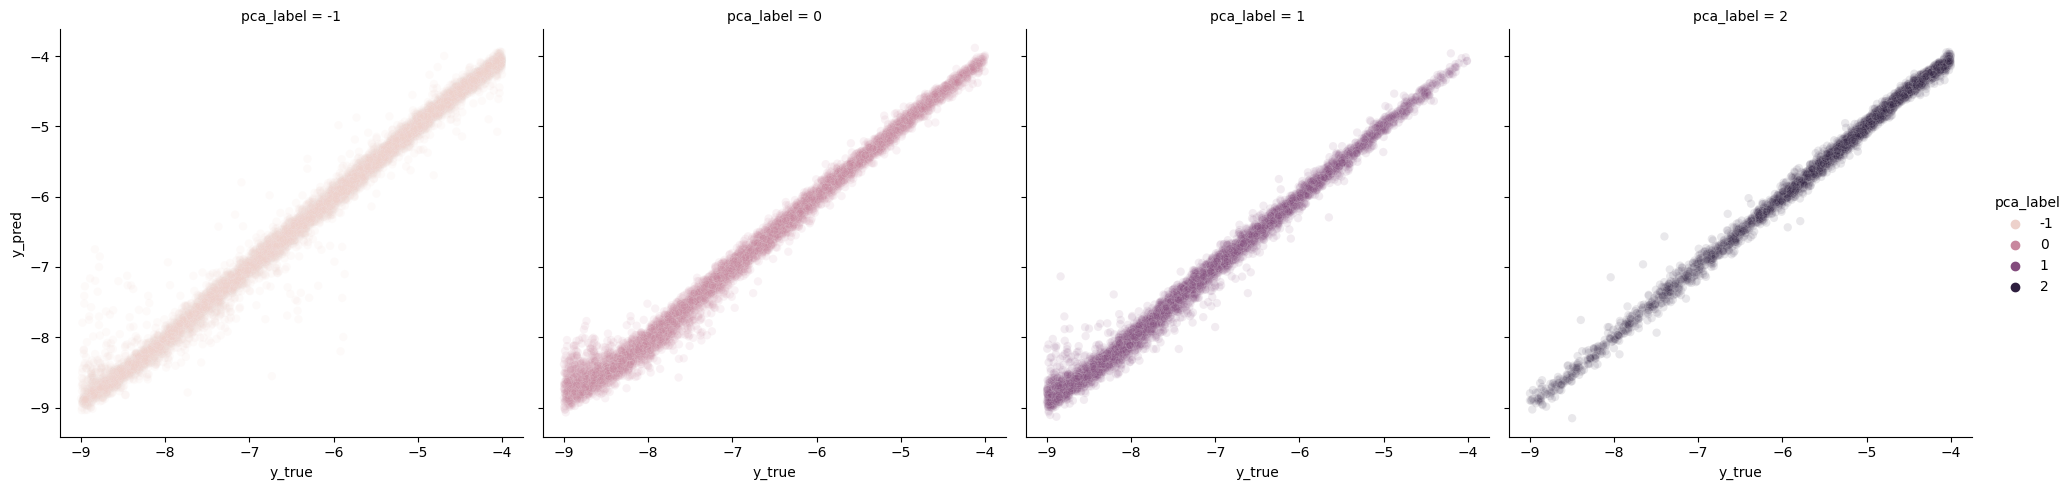

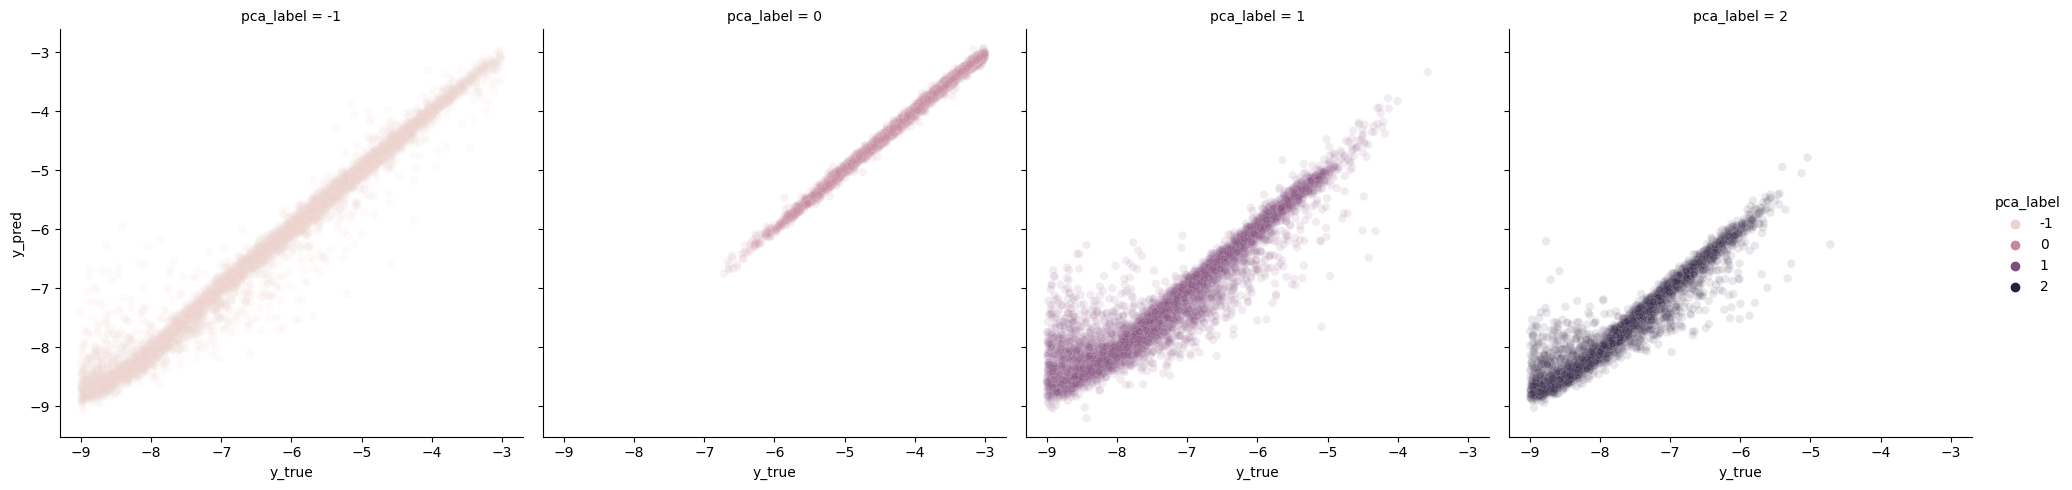

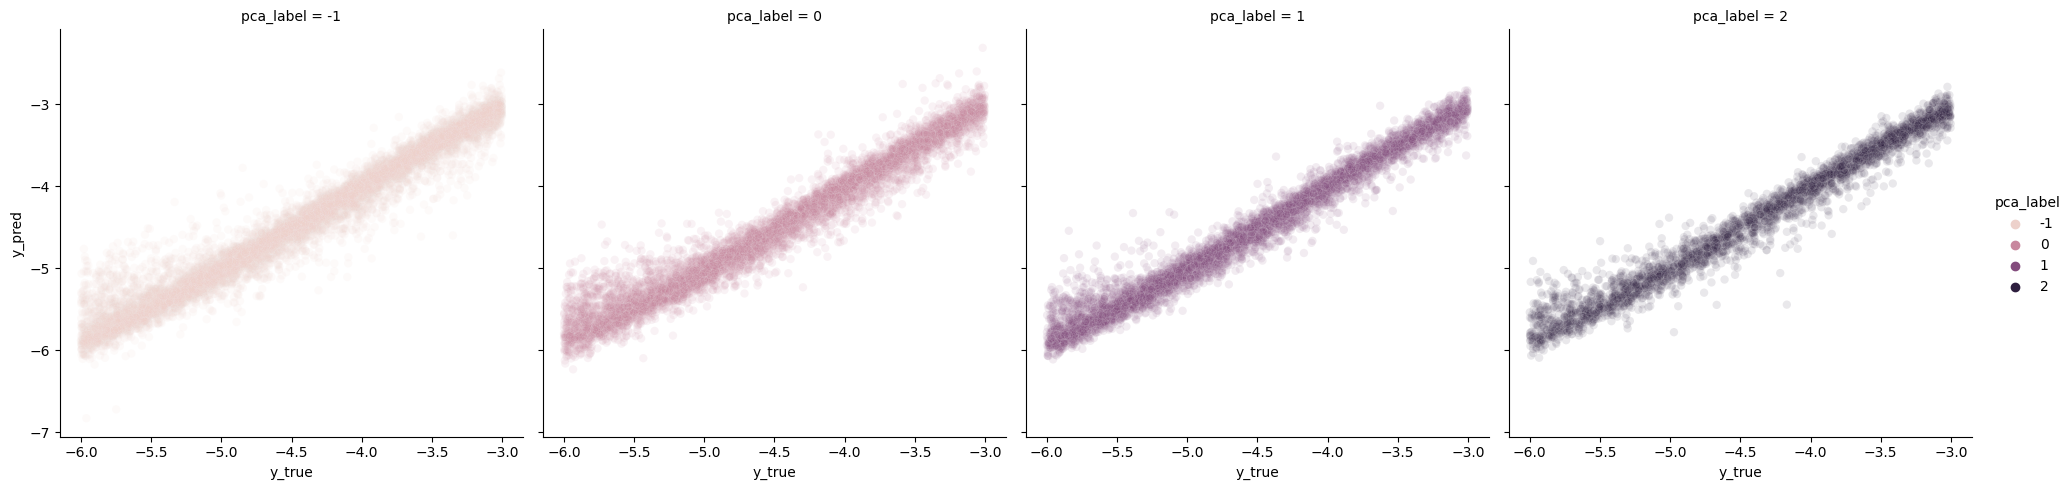

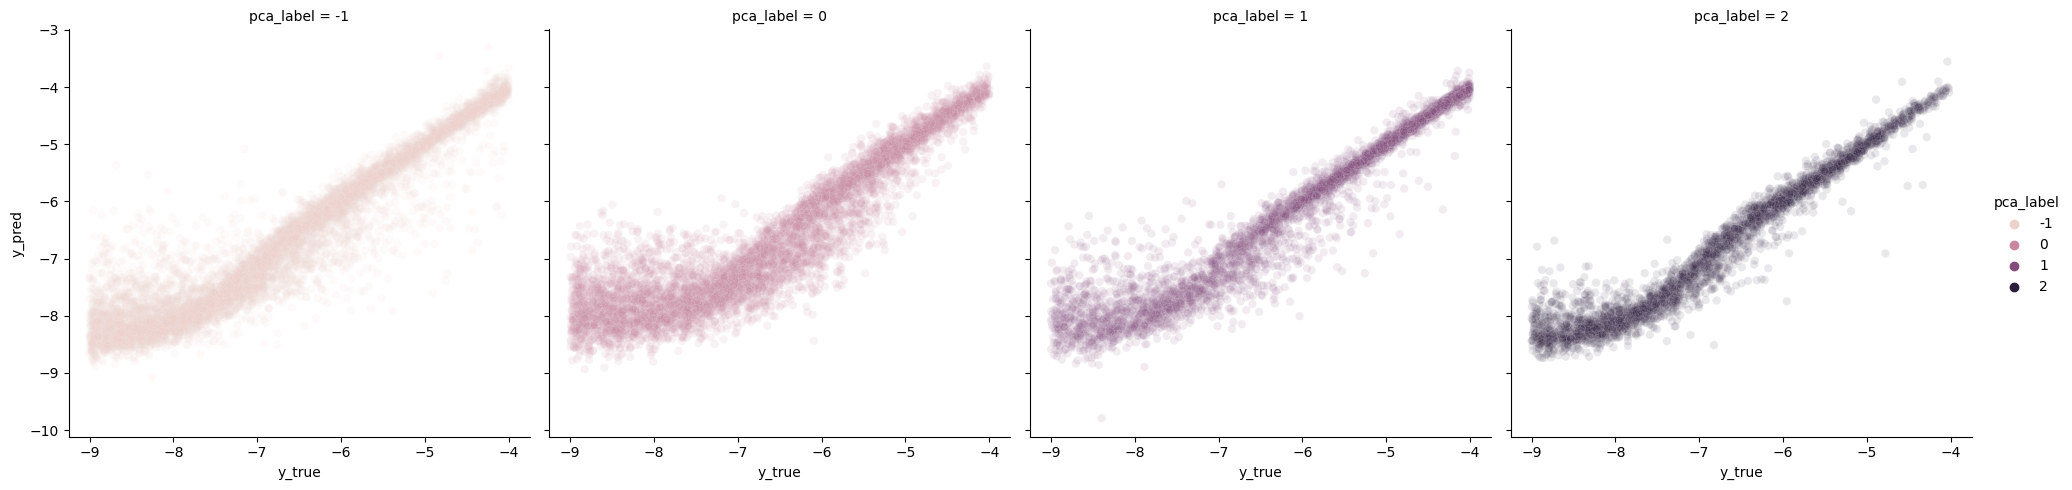

In [16]:
for i in range(0,6):
    scatterplot_by_group(i)

## Feature importances

In [17]:
def get_feature_importances(nParam):
    model = pickle.load(open("/kaggle/working/XGBmodel"+str(nParam), "rb"))
    return(model.feature_importances_)

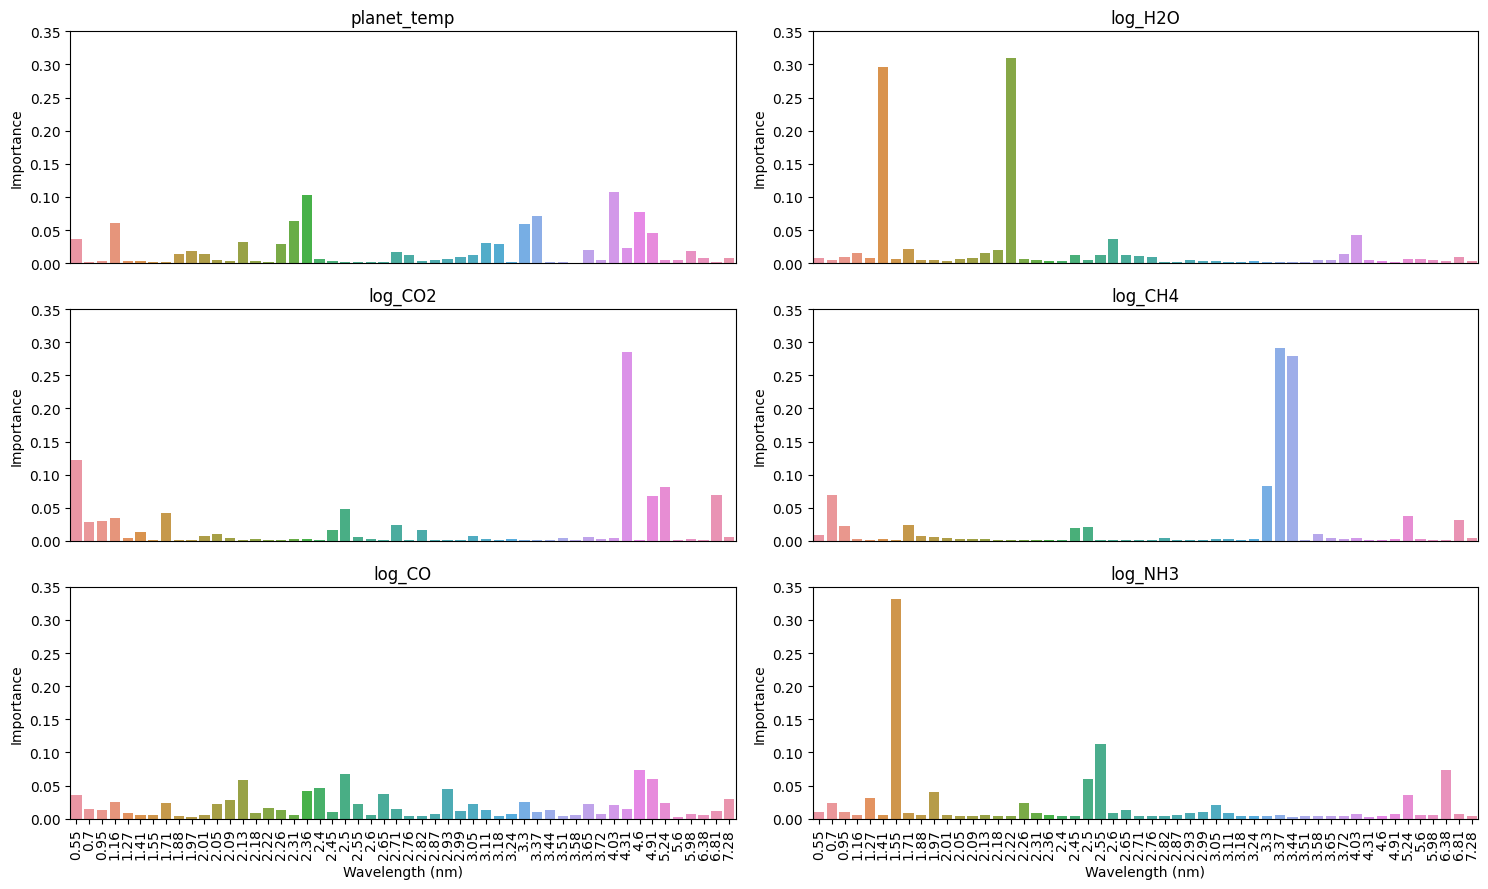

In [18]:
fig = plt.figure(figsize=(15, 9))

ymax = 0.35

ax1 = fig.add_subplot(321)
g = sns.barplot(data=pd.DataFrame({'Wavelength (nm)': X_wl_values, 'Importance': get_feature_importances(0)}), x="Wavelength (nm)", y="Importance",  ax=ax1)
g.set(title=param_names[0])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax1.xaxis.set_label_text("")
ax1.set_ylim([0,ymax])

ax2 = fig.add_subplot(322)
g = sns.barplot(data=pd.DataFrame({'Wavelength (nm)': X_wl_values, 'Importance': get_feature_importances(1)}), x="Wavelength (nm)", y="Importance",  ax=ax2)
g.set(title=param_names[1])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax2.xaxis.set_label_text("")
ax2.set_ylim([0,ymax])

ax3 = fig.add_subplot(323)
g = sns.barplot(data=pd.DataFrame({'Wavelength (nm)': X_wl_values, 'Importance': get_feature_importances(2)}), x="Wavelength (nm)", y="Importance",  ax=ax3)
g.set(title=param_names[2])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.xaxis.set_label_text("")
ax3.set_ylim([0,ymax])

ax4 = fig.add_subplot(324)
g = sns.barplot(data=pd.DataFrame({'Wavelength (nm)': X_wl_values, 'Importance': get_feature_importances(3)}), x="Wavelength (nm)", y="Importance",  ax=ax4)
g.set(title=param_names[3])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.xaxis.set_label_text("")
ax4.set_ylim([0,ymax])

ax5 = fig.add_subplot(325)
g = sns.barplot(data=pd.DataFrame({'Wavelength (nm)': X_wl_values, 'Importance': get_feature_importances(4)}), x="Wavelength (nm)", y="Importance",  ax=ax5)
g.set(title=param_names[4])
plt.xticks(rotation=90)
ax5.set_ylim([0,ymax])

ax6 = fig.add_subplot(326)
g = sns.barplot(data=pd.DataFrame({'Wavelength (nm)': X_wl_values, 'Importance': get_feature_importances(5)}), x="Wavelength (nm)", y="Importance",  ax=ax6)
g.set(title=param_names[5])
plt.xticks(rotation=90)
ax6.set_ylim([0,ymax])


plt.tight_layout()

In [19]:
def grafic_feature_importance(nParam):
    # Feature importance analysis
    feature_list = X_wl_values
    df_importances = pd.DataFrame({'Wavelength (nm)': feature_list, 'Importance': get_feature_importances(nParam)})

    g = sns.catplot(x="Wavelength (nm)", y="Importance", kind="bar", data=df_importances, height=5, aspect=2/1).set(title=param_names[nParam])
    g.set_xticklabels(rotation=90)
    plt.show()

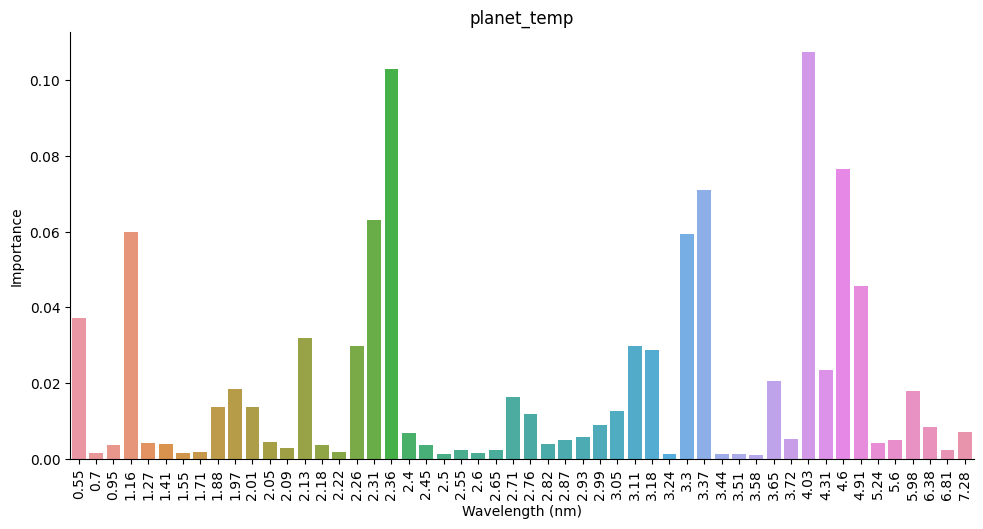

In [20]:
grafic_feature_importance(0)

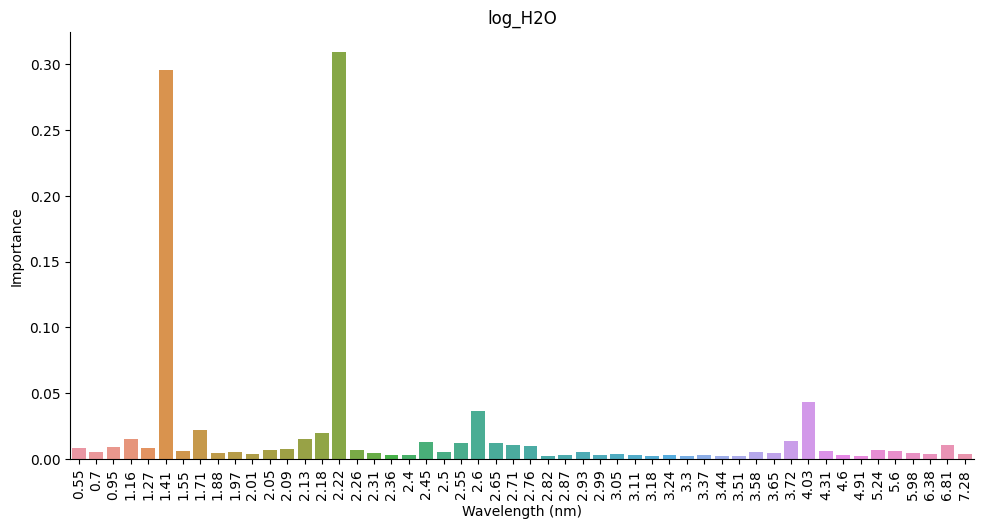

In [21]:
grafic_feature_importance(1)

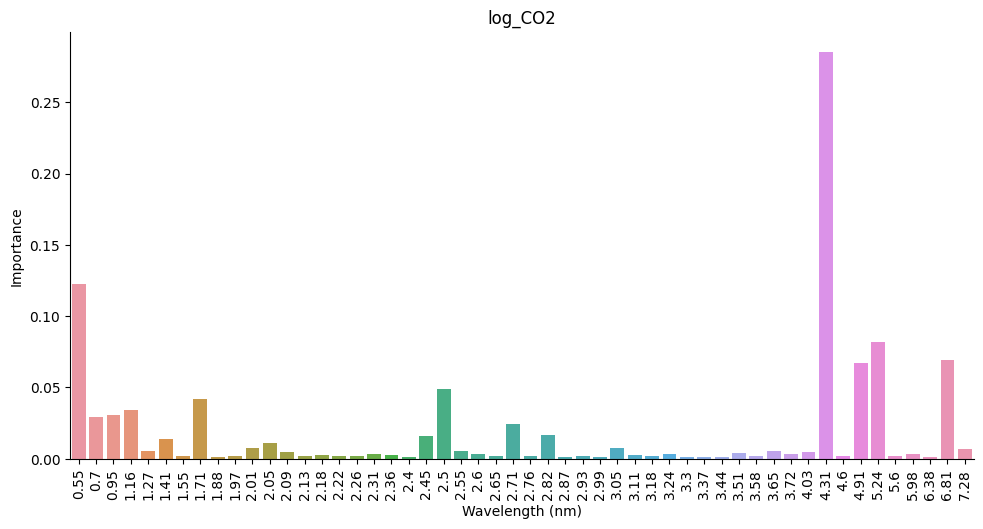

In [22]:
grafic_feature_importance(2)

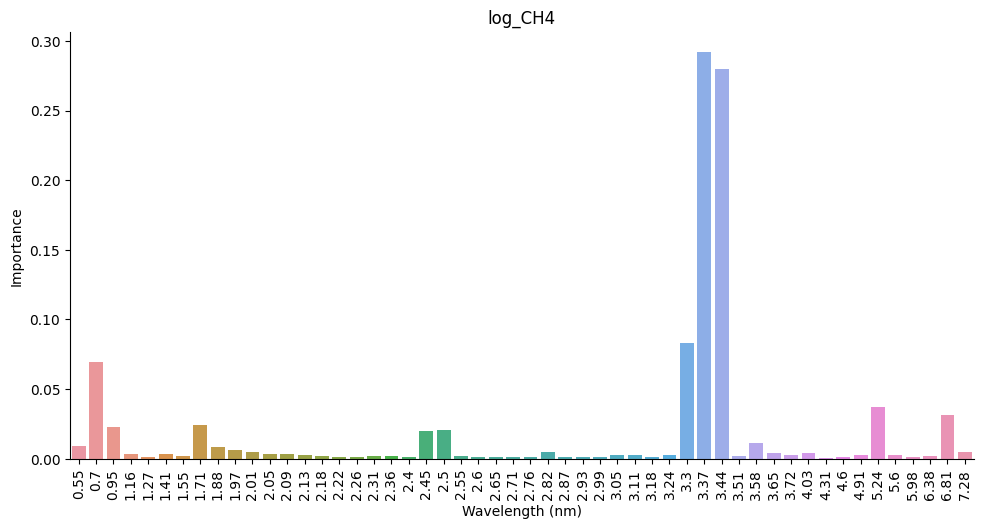

In [23]:
grafic_feature_importance(3)

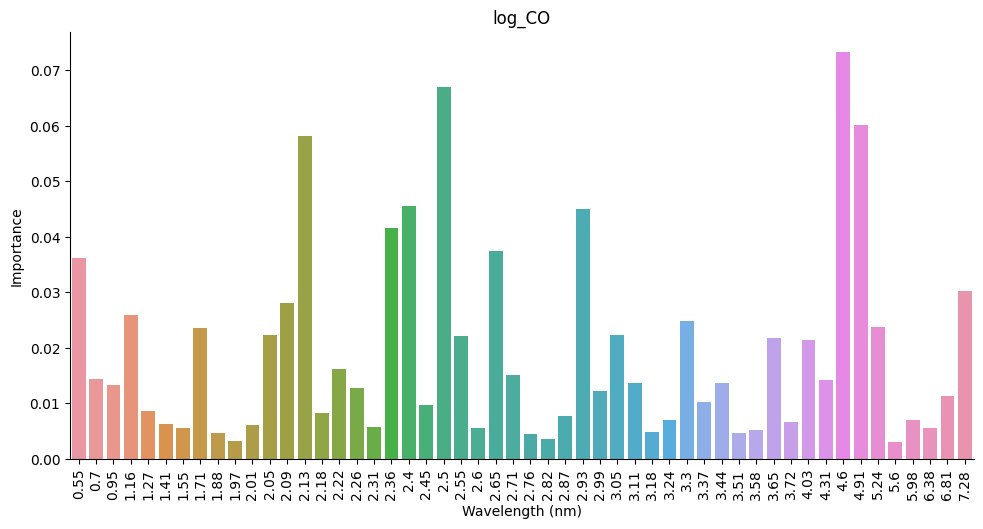

In [24]:
grafic_feature_importance(4)

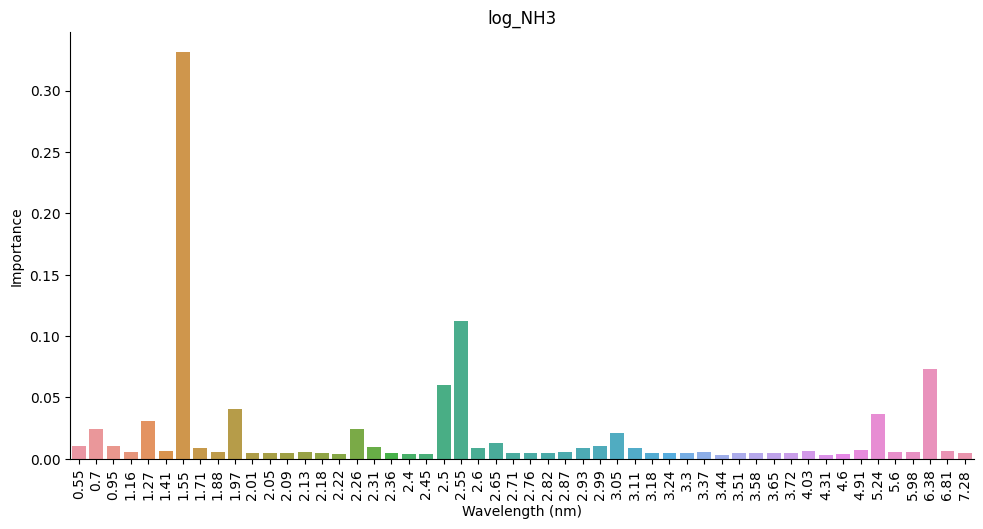

In [25]:
grafic_feature_importance(5)